# Wnioski

1. Model bazowy (TF-IDF + regresja logistyczna) stanowi stabilny punkt odniesienia i osiąga rozsądne wyniki przy minimalnej złożoności.
2. MLP na cechach TF-IDF poprawia wyniki globalne i częściowo wzmacnia wykrywanie klasy `low`, jednak klasa `mid` pozostaje najtrudniejsza do uchwycenia i wytrenowania.
3. DistilBERT ma najwyższą skuteczność ogólną (accuracy / weighted-F1), co może oznaczać, że reprezentacja kontekstowa może być korzystna.
4. Największym wyzwaniem zadania jest rozróżnienie klasy pośredniej `mid` (semantyczna niejednoznaczność i mała liczba próbek), co ogranicza macro-F1 niezależnie od klasy modelu.
5. Projekt spełnia pełny cykl ML: pozyskanie danych, preprocessing, trening trzech podejść oraz porównanie wyników i analiza błędów.


In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

id2label = {0: "low", 1: "mid", 2: "high"}
labels = ["low", "mid", "high"]

# Wczytanie danych walidacyjncyh

In [49]:
val_df = pd.read_parquet("../data/processed/val.parquet")
y_val = val_df["label"].astype(int).to_numpy()
len(y_val), np.unique(y_val, return_counts=True)



(227, (array([0, 1, 2]), array([ 29,  34, 164])))

# Wczytanie wyników MLP i DistilBERT

In [50]:
mlp_val = pd.read_csv("../results/mlp_val_predictions.csv")
bert_val = pd.read_csv("../results/distilbert_val_predictions.csv")

mlp_val.head(), bert_val.head()


(   y_true  y_pred y_true_name y_pred_name
 0       1       2         mid        high
 1       2       2        high        high
 2       2       2        high        high
 3       0       0         low         low
 4       2       2        high        high,
    y_true  y_pred y_true_name y_pred_name
 0       1       2         mid        high
 1       2       2        high        high
 2       2       2        high        high
 3       0       0         low         low
 4       2       2        high        high)

# PRedykcje regresji logistycznej

In [51]:
X_train_df = pd.read_parquet("../data/processed/train.parquet")
X_val_text = val_df["input_text"].astype(str)

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    min_df=2
)

X_train_tfidf = tfidf.fit_transform(X_train_df["input_text"].astype(str))
X_val_tfidf = tfidf.transform(X_val_text)

lr = LogisticRegression(
    max_iter=2000,
    class_weight="balanced",
    random_state=42
)
lr.fit(X_train_tfidf, X_train_df["label"].astype(int).to_numpy())

lr_pred = lr.predict(X_val_tfidf)

In [52]:
# FUNKCJA METRYK OCENY MODELI
def metrics(y_true, y_pred):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "weighted_f1": f1_score(y_true, y_pred, average="weighted"),
    }


In [53]:
summary = pd.DataFrame({
    "Regresja log (TF-IDF)": metrics(y_val, lr_pred),
    "MLP (TF-IDF)": metrics(y_val, mlp_val["y_pred"].to_numpy()),
    "DistilBERT": metrics(y_val, bert_val["y_pred"].to_numpy()),
}).T

summary

,accuracy,macro_f1,weighted_f1
Regresja log (TF-IDF),0.678414,0.547563,0.701206
MLP (TF-IDF),0.735683,0.609418,0.745424
DistilBERT,0.762115,0.540773,0.736709


# Wykres porównawczy macro-F1, weighted-F1, accuracy

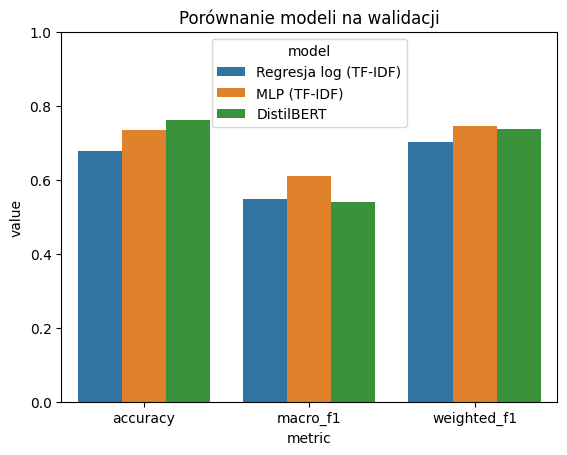

In [54]:
summary_plot = summary.reset_index().rename(columns={"index":"model"})
summary_melt = summary_plot.melt(id_vars="model", var_name="metric", value_name="value")

plt.figure()
sns.barplot(data=summary_melt, x="metric", y="value", hue="model")
plt.title("Porównanie modeli na walidacji")
plt.ylim(0, 1)
plt.show()


# Raporty klas

In [55]:
print("============ Regresja logistyczna =========")
print(classification_report(y_val, lr_pred, target_names=labels))

print("\n============       MLP         ============")
print(classification_report(y_val, mlp_val["y_pred"].to_numpy(), target_names=labels))

print("\n============   DistilBERT  ================")
print(classification_report(y_val, bert_val["y_pred"].to_numpy(), target_names=labels))


============ Regresja logistyczna =========
              precision    recall  f1-score   support

         low       0.41      0.48      0.44        29
         mid       0.31      0.50      0.39        34
        high       0.88      0.75      0.81       164

    accuracy                           0.68       227
   macro avg       0.54      0.58      0.55       227
weighted avg       0.74      0.68      0.70       227


============       MLP         ============
              precision    recall  f1-score   support

         low       0.49      0.62      0.55        29
         mid       0.41      0.47      0.44        34
        high       0.88      0.81      0.84       164

    accuracy                           0.74       227
   macro avg       0.59      0.63      0.61       227
weighted avg       0.76      0.74      0.75       227


============   DistilBERT  ================
              precision    recall  f1-score   support

         low       0.56      0.31      0.40      

# TABLICE POMYŁEK MODELI

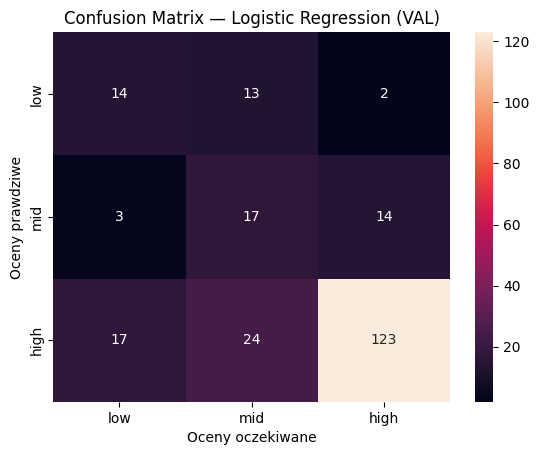

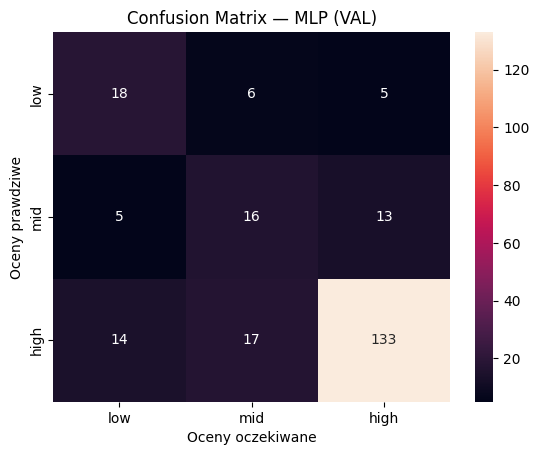

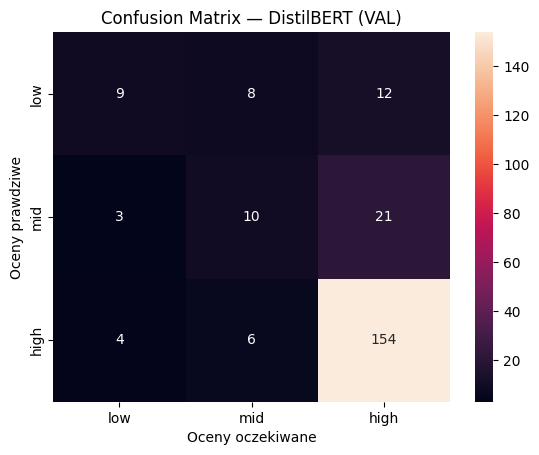

In [56]:
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure()
    sns.heatmap(cm_df, annot=True, fmt="d")
    plt.title(title)
    plt.xlabel("Oceny oczekiwane")
    plt.ylabel("Oceny prawdziwe")
    plt.show()

plot_cm(y_val, lr_pred, "Confusion Matrix — Logistic Regression (VAL)")
plot_cm(y_val, mlp_val["y_pred"].to_numpy(), "Confusion Matrix — MLP (VAL)")
plot_cm(y_val, bert_val["y_pred"].to_numpy(), "Confusion Matrix — DistilBERT (VAL)")


In [57]:
err = val_df[["id", "question", "student_answer", "label"]].copy()
err["true"] = err["label"].map(id2label)

err["lr_pred"] = pd.Series(lr_pred).map(id2label).values
err["mlp_pred"] = mlp_val["y_pred"].map(id2label).values
err["bert_pred"] = bert_val["y_pred"].map(id2label).values

# Przypadki, gdzie co najmniej jeden model się myli
mask = (err["lr_pred"] != err["true"]) | (err["mlp_pred"] != err["true"]) | (err["bert_pred"] != err["true"])
err_cases = err[mask].copy()

err_cases.sample(10, random_state=67)


,id,question,student_answer,label,true,lr_pred,mlp_pred,bert_pred
42,E04.Q01.A21,What are the two different ways of specifying ...,specify the number of elements in the array de...,2,high,high,mid,high
50,E01.Q02.A23,What stages in the software life cycle are inf...,"Removing logical errors, testing for valid dat...",0,low,low,low,mid
152,E03.Q07.A17,What are the similarities between iteration an...,they are methods of repeating the same task.,0,low,mid,mid,low
215,E03.Q04.A15,What is the main advantage associated with fun...,"If a function's arguments are large in size, c...",2,high,mid,high,high
180,E06.Q03.A22,What does the star (*) operator return?,a reference to a = variable,0,low,high,low,high
64,E04.Q05.A14,How many dimensions need to be specified when ...,when passing (in main) a multidimensional arra...,0,low,low,low,high
15,E04.Q02.A16,What is the main difference between strings de...,strings with type string are just that. String...,1,mid,low,low,low
222,E11.Q08.A01,What is the main difference between a string o...,a variable char is basically any non command k...,0,low,low,low,mid
196,E10.Q03.A06,What is a leaf?,A new item to the tree--a child,1,mid,high,high,high
32,E10.Q07.A12,How many comparisons does it take to find an e...,logn,2,high,low,low,high
